# Ollama con Langchain

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ohtar10/icesi-nlp/blob/main/Sesion6/2-ollama-langchain.ipynb)

En este notebook exploraremos una implementación simple de un modelo RAG para un corpus de [Wikihow](https://es.wikihow.com/Portada), un popular sitio con tutoriales de todo tipo. Además de eso, exploraremos el uso de [Ollama](https://ollama.com) una librería de reciente salida que facilita enormemente el poder instalar y correr localmente grandes modelos de lenguaje como [Llama 3](https://ai.meta.com/blog/meta-llama-3/) de Meta, el cual utilizarémos como motor de lenguaje base para crear un ChatBot conversacional adaptado al corpus de Wikihow en español.

**Nota:** En este notebook no se realizará el entrenamiento de ningún modelo, se utilizarán modelos pre-entrenados y se combinaran de una forma interesante para hacer uso de cada componente a su modo y crear un agente de conversación


### References
- [Newtral Simple RAG Example](https://github.com/LozanoAlvarezb/MLOPS-Newtral)
- [Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks](http://arxiv.org/abs/2005.11401)
- [Natural Language Processing with Transformers: Building Language Applications With Hugging Face](https://www.amazon.com/Natural-Language-Processing-Transformers-Applications/dp/1098103246)
- [Hugging Face Transformers](https://huggingface.co/docs/transformers/v4.41.3/en/index)

In [1]:
import pkg_resources
import warnings

warnings.filterwarnings('ignore')

installed_packages = [package.key for package in pkg_resources.working_set]
IN_COLAB = 'google-colab' in installed_packages

/tmp/ipykernel_3711968/2396000874.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [ ]:
#!test '{IN_COLAB}' = 'True' && wget  https://github.com/Ohtar10/icesi-nlp/raw/refs/heads/main/requirements.txt && pip install -r requirements.txt
!test '{IN_COLAB}' = 'True' && sudo apt-get update -y
!test '{IN_COLAB}' = 'True' && sudo apt-get install python3.10 python3.10-distutils python3.10-lib2to3 lshw -y
!test '{IN_COLAB}' = 'True' && sudo update-alternatives --install /usr/local/bin/python python /usr/bin/python3.11 2
!test '{IN_COLAB}' = 'True' && sudo update-alternatives --install /usr/local/bin/python python /usr/bin/python3.10 1
!test '{IN_COLAB}' = 'True' && pip install langchain-ollama langchain-community langchain-huggingface ollama faiss-gpu-c12 sentence-transformers gradio colab-xterm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [3]:
from datasets import load_dataset

dataset = load_dataset('somosnlp/wikihow_es', split='train')
dataset

Dataset({
    features: ['title', 'section_name', 'summary', 'document', 'english_section_name', 'english_url', 'url'],
    num_rows: 90528
})

In [4]:
import pandas as pd

pd.set_option('display.max_colwidth', 100)
dataset.set_format(type='pandas')
df = dataset.to_pandas()
df.head(15)


,title,section_name,summary,document,english_section_name,english_url,url
0,¿Cómo cultivar Delphinium?,Tomar esquejes de delphinium,"Cuando llegue marzo o abril, escoge brotes nuevos cerca de la base de la planta. Haz el corte ce...","Estos brotes serán jóvenes y sólidos, lo que es importante para un esqueje sano. A medida que la...",Taking Delphinium Cuttings,https://www.wikihow.com/Grow-Delphinium,https://es.wikihow.com/cultivar-delphinium
1,¿Cómo elegir Un buen nombre de dominio para tu sitio web?,Pensar en el futuro,Comprométete con el nombre de dominio. Escoge un nombre que deje espacio para el crecimiento. Ev...,"Cualquiera sea el nombre de dominio que escojas, debes asegurarte de comprometerte con este a la...",Thinking About the Future,https://www.wikihow.com/Pick-a-Good-Domain-Name-for-Your-Website,https://es.wikihow.com/elegir-un-buen-nombre-de-dominio-para-tu-sitio-web
2,¿Cómo hacer Tus propios regalos de navidad?,Convierte fotos en regalos,. Toma una fotografía Prueba las fotos personales.,"ecora un marco de fotos. Compra un marco de fotos barato. Puedes usar plástico, pero otros mater...",Turning Photos Into Gifts,https://www.wikihow.com/Make-Your-Own-Christmas-Gifts,https://es.wikihow.com/hacer-tus-propios-regalos-de-Navidad
3,¿Cómo soñar Despierto?,Saber qué soñar,Sueña con tu futuro deseado. Sueña con tus cosas favoritas. Actúa en tus sueños. Sueña con algo ...,Soñar despierto con una meta en mente puede ayudarte a obtener la motivación para alcanzarla. Im...,Knowing What to Dream About,https://www.wikihow.com/Daydream,https://es.wikihow.com/so%C3%B1ar-despierto
4,¿Cómo planear Una fiesta de navidad que sea elegante?,Comidas y bebidas,Debes decidir si vas a servir bebidas alcohólicas en tu fiesta: Los bocadillos y postres son una...,"en caso de hacerlo, debes tener refrescos o ponche para aquellos que no beban alcohol. También e...",Refreshments and Food,https://www.wikihow.com/Plan-an-Elegant-Christmas-Party,https://es.wikihow.com/planear-una-fiesta-de-navidad-que-sea-elegante
5,¿Cómo ver Las descargas en android?,Usar un administrador de archivos,"Abre la bandeja de aplicaciones. Pulsa Descargas, Mis archivos o Administrador de archivos. Sele...","Esta es la lista de aplicaciones del dispositivo Android. Por lo general, puedes abrirla pulsand...",Using a File Manager,https://www.wikihow.com/View-Downloads-on-Android,https://es.wikihow.com/ver-las-descargas-en-Android
6,¿Cómo deshacerse De los insectos de escama?,Eliminar los insectos de escama del jardín,Usa los mismos métodos que los que usaste para las plantas del interior al combatir un ataque de...,Estos insectos son más predominantes al aire libre donde infestan a todas las especies de árbole...,Removing Scales from the Garden,https://www.wikihow.com/Get-Rid-of-Scale-Insects,https://es.wikihow.com/deshacerse-de-los-insectos-de-escama
7,¿Cómo quitar Una mancha de vino tinto de una mesa de madera?,Mancha fresca de vino tinto,Seca el derrame de vino tinto con un paño absorbente húmedo inmediatamente. Usa una toalla suave...,Asegúrate de sólo secar el área; no lo frotes ya que se podría extender en la superficie de made...,Fresh Red Wine Stain,https://www.wikihow.com/Remove-a-Red-Wine-Stain-Ring-from-a-Wood-Table,https://es.wikihow.com/quitar-una-mancha-de-vino-tinto-de-una-mesa-de-madera
8,¿Cómo adiestrar A un gato con un clicker?,Prepárate para entrenar al gato,Consigue un clicker. Ten algunos premios a la mano. Consigue un artículo objetivo. Encuentra un ...,"Un clicker es una caja de plástico pequeña con una pestaña de metal. Al presionarla, produce un ...",Getting Ready to Train Your Cat,https://www.wikihow.com/Clicker-Train-a-Cat,https://es.wikihow.com/adiestrar-a-un-gato-con-un-clicker
9,¿Cómo hacer Un mate pastor en el ajedrez?,Realizar la jugada,Juega con las piezas blancas. e4: Bc4: Qh5: Qxf7: ¡Jaque Mate!,mueve el peón de tu rey dos cuadros hacia adelante (E2-E4). mueve el alfil del rey 3 cuadros a ...,Performing the Play,https://www.wikihow.com/D

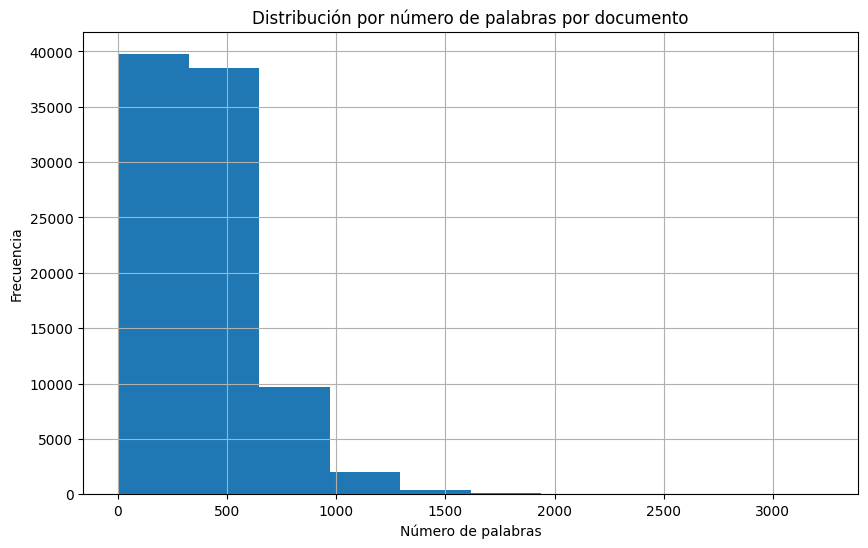

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
df.document.apply(lambda text: len(text.split(' '))).hist(ax=ax)
ax.set_title("Distribución por número de palabras por documento")
ax.set_xlabel("Número de palabras")
ax.set_ylabel("Frecuencia")
plt.show()

In [18]:
limit = 5000
documents = dataset.take(limit).map(lambda example: {"url": example['url'], "title": example['title'], "text": example['title'] + '\n' + example['summary'] + '\n' + example['document']})
documents

Map: 100%|██████████| 5000/5000 [00:04<00:00, 1240.47 examples/s]


Dataset({
    features: ['title', 'url', 'text'],
    num_rows: 5000
})

In [34]:
!if ! type ollama > /dev/null; then curl -fsSL https://ollama.com/install.sh | sh; else echo "Ollama ya está instalado."; fi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Ollama ya está instalado.


In [35]:
#%load_ext colabxterm
#%xterm

In [ ]:
!ollama pull llama3.2:1b

In [7]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.2:1b", validate_model_on_init=True)

llm.invoke("El primer hombre en la luna fue...").content

'Un tema que ha generado mucha especulación y debate entre los científicos y el público en general. Aunque no hay una respuesta definitiva, puedo darte algunas informações sobre este tema.\n\nSegún la ley de los cosmológeos, propuesto por Albert Einstein, es probable que el primer ser vivo en la Luna haya sido un organismo simple y no un hombre específico. Sin embargo, en 1959, un grupo de científicos liderado por Gerard O\'Neill propuso una teoría del "hombre lunar" o "hombre planeta", según se le conoce en inglés.\n\nDe acuerdo con esta teoría, el primer ser humano en la Luna sería un organismo artificial creativo y consciente diseñado específicamente para colonizar el espacio. Sin embargo, la idea de que alguien haya sido el primer hombre en la Luna es más una cuestión histórica y simbólica que una afirmación científica verificable.\n\nEn 1969, al ser enviado a la Luna por la misión Apolo, Neil Armstrong se convirtió en el primer hombre en la superficie lunar. Sin embargo, este hech

In [ ]:
import os
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

embeddings = HuggingFaceEmbeddings(model_name="intfloat/multilingual-e5-large")
texts = [t[0] for t in documents['text'].to_list()]

index_path = './faiss_index'
if os.path.exists(index_path):
    vectorstore = FAISS.load_local(index_path, embeddings, allow_dangerous_deserialization=True)
else:
    
    vectorstore = FAISS.from_texts(texts, embeddings)
    vectorstore.save_local(index_path)

retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

In [ ]:
prompt = PromptTemplate.from_template(
    """Utiliza los siguientes fragmentos de contexto para responder la pregunta al final.
    Si no sabes la respuesta, di que no lo sabes.
    No menciones que te he proporcionado fragmentos, simula que ya tenías esta información en tu conocimiento y responde como en una conversación natural.
    Incluye las citas a las fuentes de información

    {context}

    Pregunta: {question}
    Respuesta Útil:"""
)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type="stuff",
    chain_type_kwargs={"prompt": prompt},
    return_source_documents=True
)

result = qa_chain({"query": "Qué es el feng shui?"})

print(result["result"])
for i, doc in enumerate(result["source_documents"], 1):
    idx = vectorstore.index.reconstruct_n(0, vectorstore.index.ntotal)[0]
    try:
        original_idx = texts.index(doc.page_content)
    except ValueError:
        original_idx = None

    if original_idx is not None:
        meta = documents[original_idx]
        print(f"- [{i}] {meta['title'][0]} ({meta['url'][0]})")
    else:
        print(f"- [{i}] Unknown source: {doc.page_content[:50]}...")

El Feng Shui es una disciplina china que se centra en el arte de influir positivamente los espacios y objetos al interior del hogar para crear un ambiente saludable, pacífico y atractivo. Aunque no tiene ninguna conexión con el feng shui clásico, como las estrellas y los trascendentes, sino que se centra más en la armonía de los elementos del lugar y cómo pueden influir en nuestras vidas.
- [1] ['¿Cómo colocar Los espejos según el feng shui?'] (['https://es.wikihow.com/colocar-los-espejos-seg%C3%BAn-el-Feng-Shui'])
- [2] ['¿Cómo practicar Xeriscape?'] (['https://es.wikihow.com/practicar-xeriscape'])
- [3] ['¿Cómo incrementar La creatividad?'] (['https://es.wikihow.com/incrementar-la-creatividad'])
- [4] ['¿Cómo aprender Kung fu?'] (['https://es.wikihow.com/aprender-kung-fu'])
- [5] ['¿Cómo ser La persona que siempre has querido ser?'] (['https://es.wikihow.com/ser-la-persona-que-siempre-has-querido-ser'])


In [45]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

prompt = PromptTemplate.from_template(
    """Utiliza los siguientes fragmentos de contexto para responder la pregunta al final.
    Si no sabes la respuesta, di que no lo sabes.
    No menciones que te he proporcionado fragmentos, simula que ya tenías esta información en tu conocimiento y responde como en una conversación natural.
    Incluye las citas a las fuentes de información

    {context}

    Pregunta: {input}
    Respuesta Útil:"""
)

combine_docs_chain = create_stuff_documents_chain(llm, prompt)
qa_chain = create_retrieval_chain(retriever, combine_docs_chain)

result = qa_chain.invoke({"input": "Qué es el feng shui?"})

print(result["answer"])
for i, doc in enumerate(result["context"], 1):
    idx = vectorstore.index.reconstruct_n(0, vectorstore.index.ntotal)[0]
    try:
        original_idx = texts.index(doc.page_content)
    except ValueError:
        original_idx = None

    if original_idx is not None:
        meta = documents[original_idx]
        print(f"- [{i}] {meta['title'][0]} ({meta['url'][0]})")
    else:
        print(f"- [{i}] Unknown source: {doc.page_content[:50]}...")

El feng shui es una disciplina china que se centra en la armonía entre espacios físicos y energías (orígenes) del mundo. Se enfoca en la creación de entornos que promuevan la bienestar, el equilibrio y la felicidad humanas.
- [1] ['¿Cómo colocar Los espejos según el feng shui?'] (['https://es.wikihow.com/colocar-los-espejos-seg%C3%BAn-el-Feng-Shui'])
- [2] ['¿Cómo practicar Xeriscape?'] (['https://es.wikihow.com/practicar-xeriscape'])
- [3] ['¿Cómo incrementar La creatividad?'] (['https://es.wikihow.com/incrementar-la-creatividad'])
- [4] ['¿Cómo aprender Kung fu?'] (['https://es.wikihow.com/aprender-kung-fu'])
- [5] ['¿Cómo ser La persona que siempre has querido ser?'] (['https://es.wikihow.com/ser-la-persona-que-siempre-has-querido-ser'])


In [44]:
result

{'input': 'Qué es el feng shui?',
 'context': [Document(id='297b9168-af63-4a98-9303-5093aa2d80bd', metadata={}, page_content='¿Cómo colocar Los espejos según el feng shui?\nUtiliza espejos completos. No utilices espejos con superficies distorsionadas. Escoge espejos cuadrados o rectangulares. Evita  tener espejos rotos.\nTienes que poder verte por completo en cualquier espejo que utilices en tu hogar. Esto no quiere decir que tengas que tener la casa llena de espejos de lado a lado, pero evita aquellos que son pequeños o facetados. Lo aconsejable es poder verte de pies a cabeza. Evita escoger espejos con superficies distorsionadas. Esto también aplica a los espejos con superficies anticuadas. Se cree que observar a través de estos espejos hace que las personas se sientan distorsionadas, y esto es muy malo para el feng shui de tu hogar. Evita utilizar espejos redondeados u ovalados en tu hogar. Por lo general, los espejos cuadrados o rectangulares se consideran mejores para crear un bue

In [47]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

condense_question_system_template = (
    "Utiliza el historial de conversación y fragmentos de contexto para reformular la pregunta al final sin tener que incluir todo el historial."
    "No menciones que te he proporcionado fragmentos, simula que ya tenías esta información en tu conocimiento y responde como en una conversación natural."
)

condense_question_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", condense_question_system_template),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
    ]
)

history_aware_retriever = create_history_aware_retriever(
    llm, retriever, condense_question_prompt
)

system_prompt = (
    "Eres un asistente para tareas de tipo preguntas y respuestas."
    "Utiliza las siguientes piezas del contexto recuperado para responder la pregunta."
    "Si no sabes la respuesta, di que no lo sabes."
    "\n\n"
    "{context}"
)

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("placeholder", "{chat_history}"),
        ("human", "{input}")
    ]
)

qa_chain = create_stuff_documents_chain(llm, qa_prompt)
convo_qa_chain = create_retrieval_chain(history_aware_retriever, qa_chain)

convo_qa_chain.invoke(
    {
        "input": "qué es el feng shui?",
        "chat_history": []
    }
)


{'input': 'qué es el feng shui?',
 'chat_history': [],
 'context': [Document(id='297b9168-af63-4a98-9303-5093aa2d80bd', metadata={}, page_content='¿Cómo colocar Los espejos según el feng shui?\nUtiliza espejos completos. No utilices espejos con superficies distorsionadas. Escoge espejos cuadrados o rectangulares. Evita  tener espejos rotos.\nTienes que poder verte por completo en cualquier espejo que utilices en tu hogar. Esto no quiere decir que tengas que tener la casa llena de espejos de lado a lado, pero evita aquellos que son pequeños o facetados. Lo aconsejable es poder verte de pies a cabeza. Evita escoger espejos con superficies distorsionadas. Esto también aplica a los espejos con superficies anticuadas. Se cree que observar a través de estos espejos hace que las personas se sientan distorsionadas, y esto es muy malo para el feng shui de tu hogar. Evita utilizar espejos redondeados u ovalados en tu hogar. Por lo general, los espejos cuadrados o rectangulares se consideran mejo

In [33]:
import gradio as gr

with gr.Blocks() as gr_blocks:
    chatbot = gr.Chatbot()
    msg = gr.Textbox(
        label="Sobre qué quieres conversar?",
        placeholder="Ház tu pregunta aquí y presiona enter."
    )
    clear = gr.Button("Limpiar")

    def format_answer(response):
        answer = response["result"] + '\n'
        for i, doc in enumerate(result["source_documents"], 1):
            idx = vectorstore.index.reconstruct_n(0, vectorstore.index.ntotal)[0]
            try:
                original_idx = texts.index(doc.page_content)
            except ValueError:
                original_idx = None

            if original_idx is not None:
                meta = documents[original_idx]
                answer += f"- [{i}] {meta['title'][0]} ({meta['url'][0]})\n"
            else:
                answer += f"- [{i}] Unknown source: {doc.page_content[:50]}...\n"

    def respond(question, chat_history):
        response = qa_chain({"query": question})
        answer = format_answer(response)
        chat_history.append((question, answer))
        return "", chat_history

    def reset_chat():
        bot.reset()
        return ""

    msg.submit(respond, [msg, chatbot], [msg, chatbot])
    clear.click(reset_chat, None, chatbot, queue=False)

gr_blocks.launch(inline=False)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


IMPORTANT: You are using gradio version 4.36.1, however version 4.44.1 is available, please upgrade.
--------


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/home/ohtar10/miniconda3/envs/icesi-nlp/lib/python3.10/site-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
  File "/home/ohtar10/miniconda3/envs/icesi-nlp/lib/python3.10/site-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
  File "/home/ohtar10/miniconda3/envs/icesi-nlp/lib/python3.10/site-packages/fastapi/applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "/home/ohtar10/miniconda3/envs/icesi-nlp/lib/python3.10/site-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/home/ohtar10/miniconda3/envs/icesi-nlp/lib/python3.10/site-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/home/ohtar10/miniconda3/envs/icesi

In [ ]:
gr_blocks.close()